In [1404]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.stats import kstest, norm, zscore
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, make_scorer, f1_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler



In [1405]:
data_dev=pd.read_csv('https://files.challengerocket.com/files/lions-den-ing-2024/development_sample.csv')
data_test=pd.read_csv('https://files.challengerocket.com/files/lions-den-ing-2024/testing_sample.csv')

Preprocess function

In [1406]:
def preprocess_data(df_dev):
  df_dev = df_dev[df_dev["Application_status"] != "Rejected"]



  #calculating seniority as of the date of application
  df_dev['Var13'] = (pd.to_datetime(df_dev['application_date'], errors='coerce') - pd.to_datetime(df_dev['Var13'], errors='coerce')).dt.days
  df_dev["Var13"] = df_dev["Var13"].fillna(0)

  df_dev["Var8"] = df_dev["Var8"].fillna(0)
  df_dev["Var12"] = df_dev["Var12"].fillna(0)
  df_dev["Var18"] = df_dev["Var18"].fillna(0)
  df_dev["Var19"] = df_dev["Var19"].fillna(2)


  df_dev['Var2'] = df_dev['Var2'].fillna(3)
  df_dev['Var3'] = df_dev['Var3'].fillna(4)
  dict = {'Direct': 1,'Broker' : 2,'Online': 3}
  df_dev['Var3'] = df_dev['Var3'].replace(dict).astype(int)

  #Number of apllicants and sum of income
  df_dev['Var10'] = df_dev['Var10'].fillna(0)
  df_dev['income_sum'] = np.where(df_dev['Var10'] > 0, df_dev['Var10'] + df_dev['Var9'], 0)

  #Var10 into 01 variable
  df_dev['Var10'] = np.where(df_dev["Var10"] != 0, 1, 0)

  #filling nans iwth median spending for every professions
  median_spending_dict = {}
  prof_number = df_dev['Var11'].unique()
  for i in prof_number:
    median = df_dev.loc[df_dev['Var11'] == i, "Var17"].median()
    median_spending_dict[i] = median

  df_dev['Var17'] = df_dev['Var17'].fillna(df_dev['Var11'].map(median_spending_dict))

#-------------------------------new variables-----------------------------------
  #does a apllicant has a current account
  df_dev['current_account'] = np.where(df_dev["Var25"].isna() == True, 0, 1)


  df_dev['Var25'] = df_dev['Var25'].fillna(df_dev['Var25'].median())


  #does a apllicant has a saving account
  df_dev['saving_account'] = np.where(df_dev["Var26"].isna() == True, 0, 1)
  df_dev['Var26'] = df_dev['Var26'].fillna(df_dev['Var26'].median())

  #new var: installment to income ratio
  df_dev['installment_to_income_ratio'] = df_dev['Var7'] / df_dev['Var9'].where(df_dev['Var9'] != 0, 1)

  #new var: income to amount ratio
  df_dev['income_to_amount'] = df_dev['Var9'] / df_dev['Var4']

  #new var: income to average income ratio
  df_dev['income_to_average_income_ratio'] = df_dev['Var9'] / df_dev['Var30']

  #new var: saving to installment ratio
  df_dev['savings_to_installment_ratio'] = (df_dev['Var25'] + df_dev['Var26']) / df_dev['Var4']

  #predicted expenses to salary ratio
  df_dev['expenses_to_salary_ratio'] = df_dev['Var17'] / df_dev['Var9'].where(df_dev['Var9'] != 0, 1)

  #drop useless columns
  df_dev = df_dev.drop(["ID", "customer_id", "application_date", "Application_status"], axis=1)

  return df_dev




Features selecting function

In [1407]:
def select_features(X_train, Y_train, X_test, k=25):

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    fs = SelectKBest(score_func=chi2, k=k)
    fs.fit(X_train_scaled, Y_train)


    selected_indices = fs.get_support(indices=True)


    selected_features_names = X_train.columns[selected_indices]


    X_train_selected = X_train[selected_features_names]
    X_test_selected = X_test[selected_features_names]

    return X_train_selected, X_test_selected



Normalization and encoding functions

In [1408]:
def normalize_numeric_features(df):
    columns = df.select_dtypes(include=['float64', 'int64']).columns

    binary_columns = [col for col in columns if df[col].nunique() == 2 and set(df[col].unique()) == {0, 1}]

    numeric_columns = [col for col in columns if col not in binary_columns]

    scaler = StandardScaler()

    df.loc[:, numeric_columns] = scaler.fit_transform(df.loc[:, numeric_columns])

    return df

def encode_categorical_features(X_train):
    categorical_features = X_train.columns[27:]
    X_train_categorical = X_train[categorical_features]

    encoder = OneHotEncoder()
    encoded_data = encoder.fit_transform(X_train_categorical)


    new_column_names = encoder.get_feature_names_out(categorical_features)

    encoded_data_df = pd.DataFrame(encoded_data.toarray(), columns=new_column_names)

    return encoded_data_df

Split data

In [1409]:
numeric_features= ["Var1", "Var4", "Var5", "Var7", "Var8", "Var9", "Var10", "Var13", "Var15", "Var16", "Var17", "Var20", "Var21", "Var22", "Var23", "Var24", "Var25", "Var26", "Var29", "Var30", "income_sum", "installment_to_income_ratio", "income_to_amount", "income_to_average_income_ratio", "savings_to_installment_ratio", "expenses_to_salary_ratio"]
categorical_features = ["Var2", "Var3", "Var6", "Var11", "Var12", "Var14", "Var18", "Var19", "Var27", "Var28", "current_account", "saving_account"]

dev = preprocess_data(data_dev)
X_train = dev.iloc[:, 1:]
X_train = X_train[numeric_features + categorical_features]
Y_train = dev.iloc[:, 0].values

test = preprocess_data(data_test)
X_test = test.iloc[:, 1:]
X_test = X_test[numeric_features + categorical_features]
Y_test = test.iloc[:, 0].values



<ipython-input-1406-f999c8f9f051>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dev['Var13'] = (pd.to_datetime(df_dev['application_date'], errors='coerce') - pd.to_datetime(df_dev['Var13'], errors='coerce')).dt.days
<ipython-input-1406-f999c8f9f051>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dev["Var13"] = df_dev["Var13"].fillna(0)
<ipython-input-1406-f999c8f9f051>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Encoding

In [1410]:
X_train_cat = encode_categorical_features(X_train).set_index(np.arange(0,36718))
X_train_num = X_train[numeric_features].set_index(np.arange(0,36718 ))
X_train = pd.concat([X_train_num, X_train_cat], axis=1)

X_test_cat = encode_categorical_features(X_test).set_index(np.arange(0,3647))
X_test_num = X_test[numeric_features].set_index(np.arange(0,3647))
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

Outliers

In [1411]:
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)

mask = yhat != -1
X_train, Y_train = X_train.loc[mask], Y_train[mask]



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Normalization

In [1412]:
X_train = normalize_numeric_features(X_train)
X_test = normalize_numeric_features(X_test)



SMOTE oversampling

In [1413]:
smote = SMOTE(random_state=42,sampling_strategy = 0.3)


X_oversampled, Y_oversampled = smote.fit_resample(X_train, Y_train)


# Model

Coefficients: [[-7.19452666e-02  4.16257736e-01 -9.94651788e-02  1.33871755e-01
  -5.81751614e-01 -9.38034696e-02 -1.92107020e-01 -8.28746278e-04
  -1.76660728e-01  1.68198014e-01  5.54343076e-01 -8.05356254e-03
  -4.53791194e-02  2.04036203e-01 -6.00212924e-02 -5.85355979e-02
  -4.06424963e-01 -4.37012161e-01  3.04256683e-01 -3.62237063e-02
  -2.48732539e-01 -4.34798219e-04  4.29301003e-02 -2.62396222e-02
  -1.72763625e-02  3.85464301e-02 -2.41205146e-02  8.21588258e-03
   9.44324455e-02 -7.85278135e-02  2.50986378e-01  2.24715342e-01
  -4.75701720e-01  9.26673292e-01 -9.72633008e-01 -1.08358747e+00
  -3.19969491e-01 -1.32271730e-01 -3.17151051e-01  1.89893945e+00
  -3.52322084e-01  1.34744665e+00 -1.10196343e+00  1.12996670e-01
  -4.17675879e-01 -7.18495323e-02 -6.10614997e-02  5.44429105e-01
   5.48804442e-02 -3.32551693e-01 -3.26523065e-01  4.23305712e-01
   1.80888601e-01  5.34670836e-01 -5.34670836e-01 -7.09500154e-02
   7.31989516e-02 -2.24893623e-03 -2.42457222e-01  2.42457222e

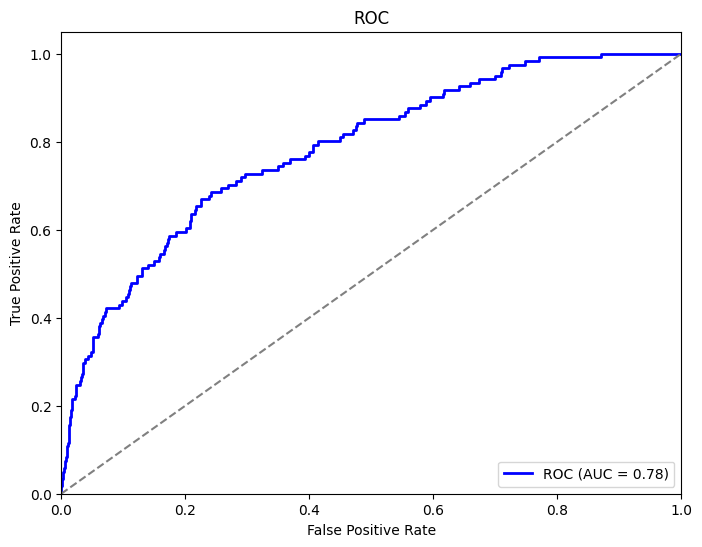

In [1414]:
w = {0:1, 1:7.15151515}

model = LogisticRegression(random_state=13,class_weight=w, solver="newton-cholesky", penalty="l2")
model.fit(X_train, Y_train)

probabilities = model.predict_proba(X_test)[:, 1]

predicted_classes = model.predict(X_test)
precision = precision_score(Y_test, predicted_classes)

#Recall
recall = recall_score(Y_test, predicted_classes)
accuracy = accuracy_score(Y_test, predicted_classes)
#ROC
fpr, tpr, _ = roc_curve(Y_test, probabilities)
AUC = auc(fpr, tpr)


print("Coefficients:", model.coef_)

print("Precision: ", precision)
print("Recall: ", recall)
print(f"Roc: {AUC}")
print(f'Confusion Matrix: \n{confusion_matrix(Y_test, predicted_classes)}')
print(f"f1 score {f1_score(Y_test, predicted_classes)}")
print(f"accuracy {accuracy}")

gini_index = 2 * AUC - 1

print("Gini:", gini_index)




# ROC plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC (AUC = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

**Challenger Model**

In [1416]:
dev = preprocess_data(data_dev)
X_train = dev.iloc[:, 1:]
X_train = X_train[numeric_features + categorical_features]
Y_train = dev.iloc[:, 0].values

test = preprocess_data(data_test)
X_test = test.iloc[:, 1:]
X_test = X_test[numeric_features + categorical_features]
Y_test = test.iloc[:, 0].values

<ipython-input-1406-f999c8f9f051>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dev['Var13'] = (pd.to_datetime(df_dev['application_date'], errors='coerce') - pd.to_datetime(df_dev['Var13'], errors='coerce')).dt.days
<ipython-input-1406-f999c8f9f051>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dev["Var13"] = df_dev["Var13"].fillna(0)
<ipython-input-1406-f999c8f9f051>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Precision:  0.7419354838709677
Recall:  0.19008264462809918
Roc: 0.787374075931803
Confusion Matrix: 
[[3441   85]
 [  93   28]]
accuracy 0.9709350150808884
f1 score 0.23931623931623933


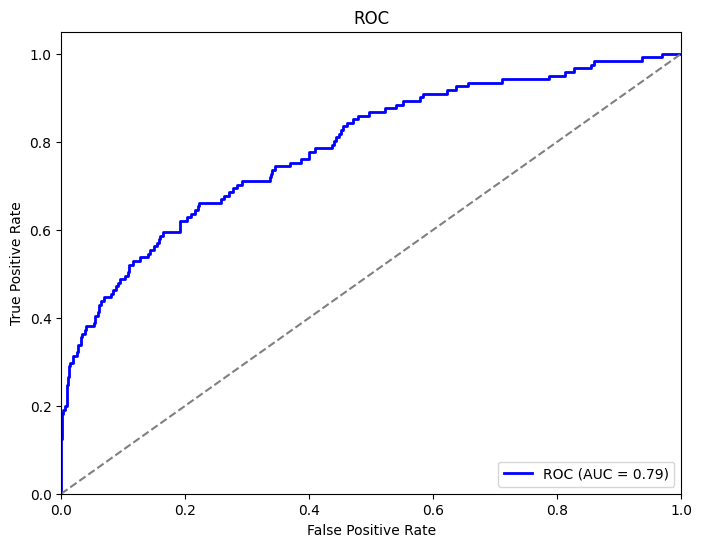

In [1417]:
model = XGBClassifier()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

y_proba = model.predict_proba(X_test)[:, 1]



fpr, tpr, thresholds = roc_curve(Y_test, y_proba)
AUC = auc(fpr, tpr)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)

f1 = f1_score(Y_test, y_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print(f"Roc: {AUC}")
print(f'Confusion Matrix: \n{confusion_matrix(Y_test, predicted_classes)}')
print(f"accuracy {accuracy}")
print(f"f1 score {f1_score(Y_test, predicted_classes)}")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC (AUC = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()




In [ ]:
best_f1_score = 0
best_weight = None
weights = np.linspace(0, 30, 30)

# Iteracja po różnych wagach
for weight in weights:

    model = LogisticRegression(class_weight={0: 1, 1: weight})
    model.fit(X_train, Y_train)

    # Przewidywanie klas dla zbioru testowego
    y_pred = model.predict(X_test)

    # Obliczenie F1 score
    score = f1_score(Y_test, y_pred)

    # Aktualizacja najlepszych wag
    if score > best_f1_score:
        best_f1_score = score
        best_weight = weight

print("Best F1 Score:", best_f1_score)
print("Best Weight for class 1:", best_weight)